# 线性最小二乘法
## 最小二乘法拟合
假设我们要将一个点序列ys表示成另一个序列xs的函数。如果xs和ys之间存在线性关系，截距为inter，斜率为slope，那么我们就可以预期每个：

    y[i] = inter + slope * x[i]

实际数据到拟合线的残差(residual)为：

    res = ys - (inter + slope * xs)

选择使残差平方和最小。

## 实现
计算新生儿体重与母亲年龄的关系。

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg

In [2]:
def MakeFrames():
    """Reads pregnancy data and partitions first babies and others.

    returns: DataFrames (all live births, first babies, others)
    """
    preg = nsfg.ReadFemPreg()

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert len(live) == 9148
    assert len(firsts) == 4413
    assert len(others) == 4735

    return live, firsts, others

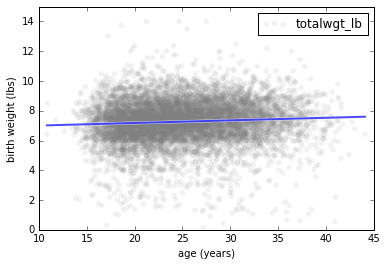

In [3]:
def PlotFit(live):
    """Plots a scatter plot and fitted curve.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    inter, slope = thinkstats2.LeastSquares(ages, weights)
    fit_xs, fit_ys = thinkstats2.FitLine(ages, inter, slope)

    thinkplot.Scatter(ages, weights, color='gray', alpha=0.1)
    thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
    thinkplot.Plot(fit_xs, fit_ys, color='blue', linewidth=2)
    thinkplot.Config(root='linear1',
                   xlabel='age (years)',
                   ylabel='birth weight (lbs)',
                   axis=[10, 45, 0, 15],
                   legend=False)
live, _, _ = MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
PlotFit(live)

计算得到的截距和斜率的估计值分别为6.8磅和每年0.017磅。母亲的年龄均值为25岁，那么25岁母亲产下的婴儿的平均体重为7.3磅。

## 残差

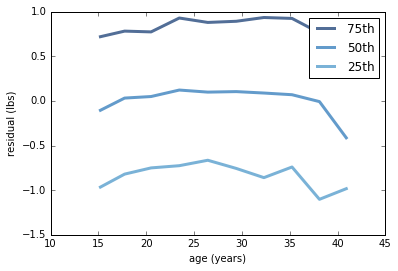

In [4]:
def PlotResiduals(live):
    """Plots percentiles of the residuals.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    inter, slope = thinkstats2.LeastSquares(ages, weights)
    live['residual'] = thinkstats2.Residuals(ages, weights, inter, slope)

    bins = np.arange(10, 48, 3)
    indices = np.digitize(live.agepreg, bins)
    groups = live.groupby(indices)

    ages = [group.agepreg.mean() for _, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(root='linear2',
                   xlabel='age (years)',
                   ylabel='residual (lbs)',
                   xlim=[10, 45])
PlotResiduals(live)

上图展示了每个年龄组残差的第25，第50和第75百分位秩。中位数值接近0，四分位距约为2磅。因此，如果我们已知母亲的年龄，就可以有50%的概率将新生儿体重估计精确到磅。

理想情况下，这些线应该是平的，说明残差是随机的；这些线还应该是平行的，说明所有年龄组的残差方差都很小。

## 估计
参数slope和inter是基于样本估计得到的，会受到抽样偏倚、测量误差和抽样误差的影响。模拟实验的方法是对数据进行重抽样。

In [5]:
def Summarize(estimates, actual=None):
    """Prints standard error and 90% confidence interval.

    estimates: sequence of estimates
    actual: float actual value
    """
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

def SamplingDistributions(live, iters=101):
    """Estimates sampling distributions by resampling rows.

    live: DataFrame
    iters: number of times to run simulations

    returns: pair of sequences (inters, slopes)
    """
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

def EstimateBirthWeight(live, iters=1001):
    """Estimate mean birth weight by resampling, with and without weights.

    live: DataFrame
    iters: number of experiments to run
    """

    mean = live.totalwgt_lb.mean()
    print('mean', mean)

    estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
                 for _ in range(iters)]
    Summarize(estimates)

live, _, _ = MakeFrames()
EstimateBirthWeight(live)

mean 7.26562845762
mean, SE, CI 7.26502732172 0.0146714757417 (7.2418343097159283, 7.288937258153676)


计算的到截距的估计值的均值为7.27，90%置信区间为 (7.24, 7.29)

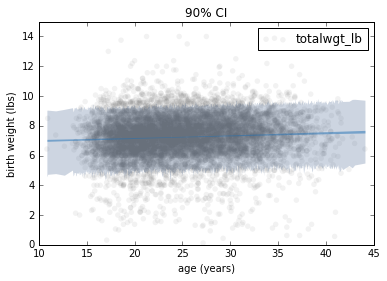

In [6]:
def PlotConfidenceIntervals(xs, inters, slopes, 
                            res=None, percent=90, **options):
    """Plots the 90% confidence intervals for weights based on ages.

    xs: sequence
    inters: estimated intercepts
    slopes: estimated slopes
    res: residuals
    percent: what percentile range to show
    """
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        if res is not None:
            fys += np.random.permutation(res)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

def PlotSamplingDistributions1(live):
    """Plots confidence intervals for the fitted curve and sampling dists.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    inter, slope = thinkstats2.LeastSquares(ages, weights)
    res = thinkstats2.Residuals(ages, weights, inter, slope)
    inters, slopes = SamplingDistributions(live, iters=1001)
    
    # plot the confidence intervals
    thinkplot.PrePlot(2)
    thinkplot.Scatter(ages, weights, color='gray', alpha=0.1)
    PlotConfidenceIntervals(ages, inters, slopes, res=res, alpha=0.2)
    PlotConfidenceIntervals(ages, inters, slopes)
    thinkplot.Config(root='linear5',
                   xlabel='age (years)',
                   ylabel='birth weight (lbs)',
                   title='90% CI',
                   axis=[10, 45, 0, 15],
                   legend=False)
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
PlotSamplingDistributions1(live)

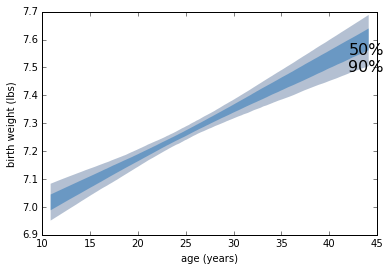

In [7]:
def PlotSamplingDistributions2(live):
    """Plots confidence intervals for the fitted curve and sampling dists.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    
    # plot the confidence intervals
    inters, slopes = SamplingDistributions(live, iters=1001)
    PlotConfidenceIntervals(ages, inters, slopes, percent=90, 
                            alpha=0.3, label='90% CI')
    thinkplot.Text(42, 7.53, '90%')
    PlotConfidenceIntervals(ages, inters, slopes, percent=50,
                            alpha=0.5, label='50% CI')
    thinkplot.Text(42, 7.59, '50%')

    thinkplot.Config(root='linear3',
                   xlabel='age (years)',
                   ylabel='birth weight (lbs)',
                   legend=False)
PlotSamplingDistributions2(live)

对新生儿与母亲年龄关系的拟合曲线，上图展示了其50%和90%置信区间。图中区域的竖直宽度代表抽样误差的影响。抽样误差对均值附近的值影响较小，对极端值影响较大。

## 拟合优度
- Std(res):如果使用线性模型进行预测，那么Std(res)就是预测值的均方根误差。
- Std(ys):如果在不知道母亲年龄的情况下估计新生儿的体重，那么估计值的均方根误差为Std(ys)。
- 决定系数(coefficient od determination)，通常写成$R^2$。

        def CoefDetermination(ye, res):
            return 1- Var(res) / Var(ys)

    - 其中Var(res)是使用模型进行猜测的均方误差，Var(ys)是不使用模型时的均方误差。因此，这两个值的比率是使用模型仍存在的均方误差比例，$R^2$是该模型消除的均方误差比例。
    - 决定系数和Pearson相关系数之间存在一个简单关系：$R^2=\rho^2$。例如，如果p=0.8或-0.8，那么$R^2=0.64$。

In [8]:
import math

def PlotSamplingDistributions3(live):
    """Plots confidence intervals for the fitted curve and sampling dists.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    inter, slope = thinkstats2.LeastSquares(ages, weights)
    res = thinkstats2.Residuals(ages, weights, inter, slope)
    r2 = thinkstats2.CoefDetermination(weights, res)

    print('rho', thinkstats2.Corr(ages, weights))
    print('R2', r2)
    print('R', math.sqrt(r2))
    print('Std(ys)', thinkstats2.Std(weights))
    print('Std(res)', thinkstats2.Std(res))

live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
PlotSamplingDistributions3(live)

rho 0.0688339703541
R2 0.00473811547471
R 0.0688339703541
Std(ys) 1.40821553384
Std(res) 1.40487542879


- Std(res)为1.40磅，Std(ys)为1.41磅，因此在这个示例中，已知母亲年龄并不能显著提高预测的准确度。
- $R^2$为0.0047，说明使用母亲年龄大约能预测新生儿体重变化中1%的一半。

## 检验线性模型
一种方法是检验均方根误差的显著降低是否偶然。在这个检验中，检验统计量是$R^2$，原假设为变量之间不存在关系。通过置换对原假设进行检验。实际上，由于$R^2=\rho^2$，$R^2$的单侧检验等效于p的双侧检验。我们已经进行过这项检验，得到p<0.001，因此认为母亲年龄和新生儿体重之间的直观效应是统计显著的。

另一种方法是检验斜率是否偶然。在这个检验中，原假设是斜率实际为0。因此，可以使用均值附近的随机变化建立新生儿体重模型。

代码使用的数据为年龄和体重序列。检验统计量为LeastSquares估计的斜率。代码使用所有新生儿体重的均值和到均值的偏差表示原假设模型。代码对偏差进行置换，然后叠加在均值上，从而生成模拟数据。

得到的p值小于0.001。因此，虽然估计斜率很小，当不太可能是偶然产生的。

p-value, sampling distribution 0.0
p-value, slope test 0.0
inter 6.83039697331 6.83384519844
mean, SE, CI 6.83384519844 0.0722729956708 (6.7146282569131994, 6.9533262231734776)
slope 0.0174538514718 0.0173111631746
mean, SE, CI 0.0173111631746 0.0028657594794 (0.012641531199386848, 0.022119849967809174)


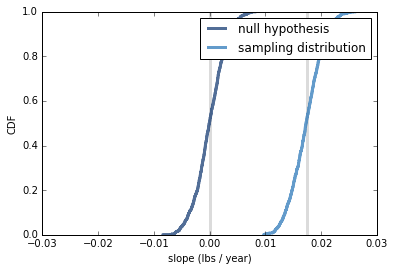

In [9]:
class SlopeTest(thinkstats2.HypothesisTest):
    """Tests the slope of a linear least squares fit. """

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        """Builds a model of the null hypothesis.
        """
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        """Runs the model of the null hypothesis.

        returns: simulated data
        """
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

def PlotSamplingDistributions4(live):
    """Plots confidence intervals for the fitted curve and sampling dists.

    live: DataFrame
    """
    ages = live.agepreg
    weights = live.totalwgt_lb
    inter, slope = thinkstats2.LeastSquares(ages, weights)

    # plot the sampling distribution of slope under null hypothesis
    # and alternate hypothesis
    inters, slopes = SamplingDistributions(live, iters=1001)
    sampling_cdf = thinkstats2.Cdf(slopes)
    print('p-value, sampling distribution', sampling_cdf[0])

    ht = SlopeTest((ages, weights))
    pvalue = ht.PValue()
    print('p-value, slope test', pvalue)

    print('inter', inter, thinkstats2.Mean(inters))
    Summarize(inters, inter)
    print('slope', slope, thinkstats2.Mean(slopes))
    Summarize(slopes, slope)

    thinkplot.PrePlot(2)
    thinkplot.Plot([0, 0], [0, 1], color='0.8')
    ht.PlotCdf(label='null hypothesis')
    thinkplot.Cdf(sampling_cdf, label='sampling distribution')
    thinkplot.Config(root='linear4',
                   xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   loc='upper left')
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
PlotSamplingDistributions4(live)

上图展示了斜率分布抽样，以及原假设下生成的斜率分布。抽样分布中间值约为估计斜率，即0.017磅/年。原假设下的斜率中间值约为0.除此之外，这两个分布是一样的，而且还是对称的。

因此，我们可以用两种方法估计p值：
- 计算原假设下斜率大于观测斜率的概率。
- 计算抽样分布中斜率小于0的概率（如果估计斜率为负数，那么应该计算抽样分布中斜率大于0的概率）

我们通常会计算参数的抽样分布，因此第二种方法较为容易。而且第二种方法计算的值较为准确，除非样本规模很小而且残差分布偏斜。即便如此，第二种方法计算的值通常也很不错，因为p值并不需要特别准确。下面的代码使用抽样分布估计斜率的p值：

    inters, slopes = SamplingDistributions(live, iters=1001)
    slope_cdf = thinkstat2.Cdf(slopes)
    pvalue = slope_cdf[0]

结果再一次得到p<0.001。